### Playback walk motion

In [1]:
import time,pickle,mujoco
import numpy as np
import cv2,glob,os
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists,r2quat
import mediapy as media

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse

In [2]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='MyoSuite',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.9,0.9,0.9,0.5]
print ("Done.")

Done.


In [3]:
for idx, name in enumerate(env.body_names):
    print(idx, name)

0 world
1 base
2 root
3 spine1
4 spine2
5 spine3
6 neck
7 head
8 left_collar
9 left_shoulder
10 left_elbow
11 left_wrist
12 left_index1
13 left_index2
14 left_index3
15 left_index4
16 left_middle1
17 left_middle2
18 left_middle3
19 left_middle4
20 left_ring1
21 left_ring2
22 left_ring3
23 left_ring4
24 left_pinky1
25 left_pinky2
26 left_pinky3
27 left_pinky4
28 left_thumb1
29 left_thumb2
30 left_thumb3
31 left_thumb4
32 right_collar
33 right_shoulder
34 right_elbow
35 right_wrist
36 right_index1
37 right_index2
38 right_index3
39 right_index4
40 right_middle1
41 right_middle2
42 right_middle3
43 right_middle4
44 right_ring1
45 right_ring2
46 right_ring3
47 right_ring4
48 right_pinky1
49 right_pinky2
50 right_pinky3
51 right_pinky4
52 right_thumb1
53 right_thumb2
54 right_thumb3
55 right_thumb4
56 left_pelvis
57 left_knee
58 left_ankle
59 right_pelvis
60 right_knee
61 right_ankle


### Load walking motion

In [4]:
pkl_path = '../data/smplrig_cmu_walk_optimized_recon.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)
qs         = data['qpos'] # [L * Nj]
# quat_roots = data['rotation'][:,0,:]
p_roots    = data['p_root']
R_roots    = data['R_root']
xposes     = data['xpos']
L = qs.shape[0]
HZ = 500
times = np.linspace(0,L/HZ,L)
print ("[%s] loaded."%(pkl_path))

[../data/smplrig_cmu_walk_optimized_recon.pkl] loaded.


In [5]:
R_roots

array([[ 0.74,  0.05,  0.02, -0.67],
       [ 0.74,  0.05,  0.02, -0.67],
       [ 0.74,  0.04,  0.02, -0.67],
       ...,
       [ 0.66, -0.  ,  0.08, -0.75],
       [ 0.66, -0.  ,  0.08, -0.75],
       [ 0.66, -0.  ,  0.09, -0.75]])

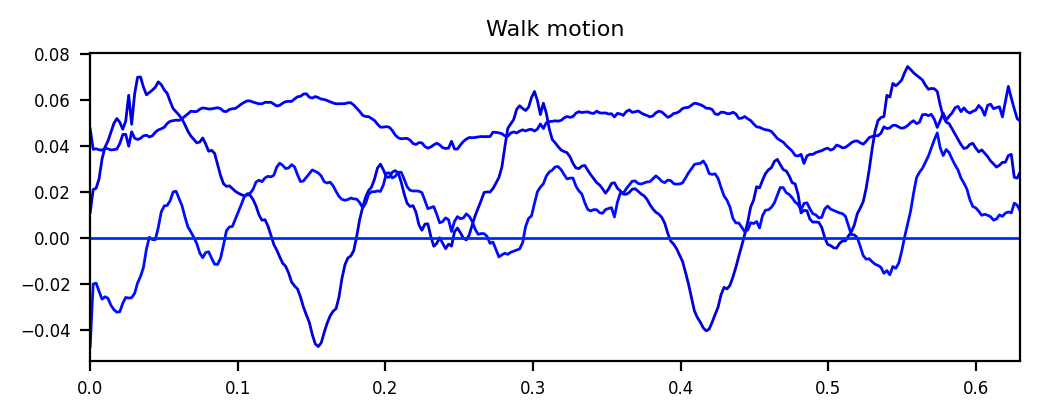

In [6]:
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,qs.shape[1]))
for i_idx in [3,4,5,6]:#:range(qs.shape[1]):
    plt.plot(times,qs[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([times[0],times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

In [7]:
# Set which joints to control
rev_joint_names = env.rev_joint_names
joint_idxs_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=rev_joint_names)
q_rev_init = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

In [8]:
# n_rev_joint
np.concatenate((env.rev_joint_mins,env.pri_joint_mins)).shape

(37,)

In [9]:
qrev_sliders = MultiSliderClass(
    n_slider      = n_rev_joint,
    title         = 'Joint position slider',
    window_width  = 500,
    window_height = 800,
    x_offset      = 100,
    y_offset      = 200,
    slider_width  = 350,
    label_texts   = rev_joint_names,
    slider_mins   = np.concatenate((env.rev_joint_mins,env.pri_joint_mins)),
    slider_maxs   = np.concatenate((env.rev_joint_maxs,env.pri_joint_maxs)),
    slider_vals   = q_rev_init,
    resolution    = 0.01,
    VERBOSE       = False
)

tick_slider = MultiSliderClass(
    n_slider      = 1,
    title         = 'Tick slider',
    window_width  = 500,
    window_height = 100,
    x_offset      = 100,
    y_offset      = 0,
    slider_width  = 350,
    label_texts   = ['Tick'],
    slider_mins   = [0],
    slider_maxs   = [L-1],
    slider_vals   = [0],
    resolution    = 0.5,
    ADD_PLAYBACK  = True,
    VERBOSE       = False
)
print ("Slider ready.")

Slider ready.


In [10]:
# Configuration
PLOT_EVERY = 4
SAVE_VID   = False
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[4] SAVE_VID:[0]


### Loop

In [11]:
qs.shape

(315, 37)

2024-02-28 12:50:03.236 python[63717:21109868] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Pressed ESC
Quitting.


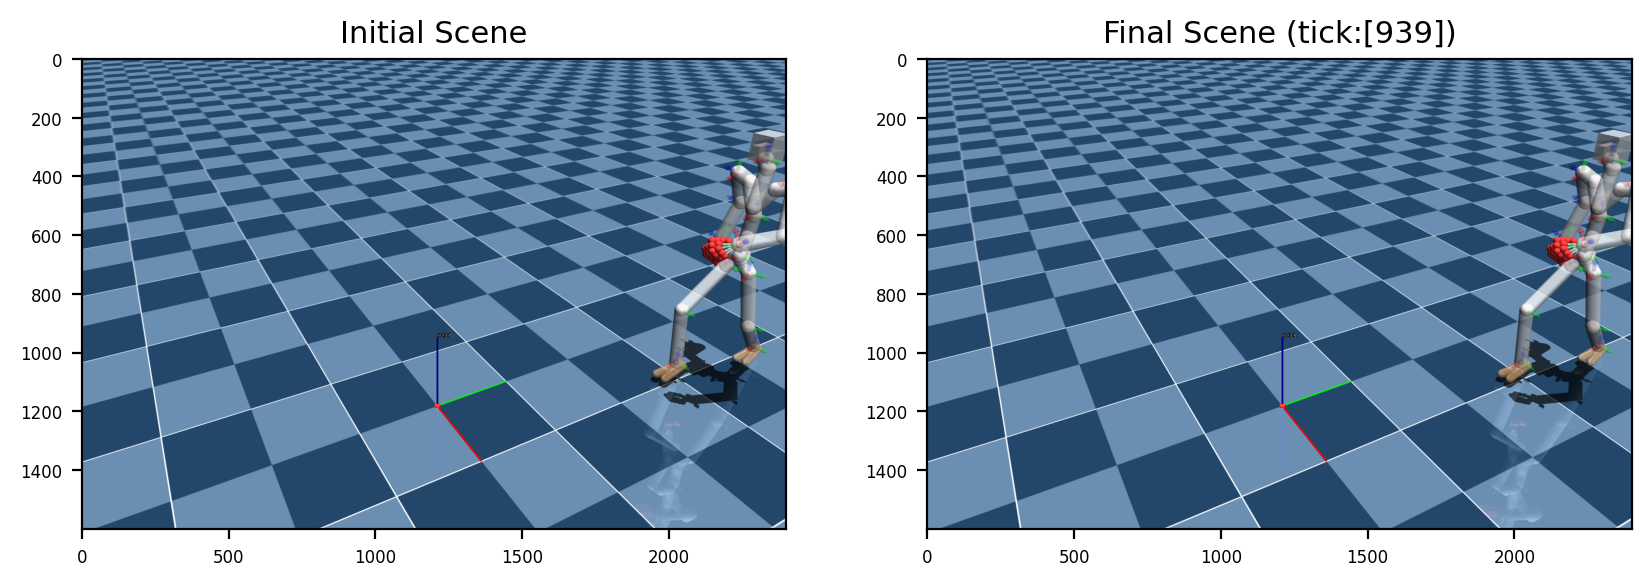

Done.


In [12]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPL Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()
FIRST_FLAG = True
while env.is_viewer_alive():

    # Update
    time.sleep(5e-3) # little delay helps
    qrev_sliders.update()
    tick_slider.update()
    if tick_slider.PLAYBACK: # play mode
        tick = min(tick+1,L-1)
        if tick == (L-1): tick_slider.reset_playback()
        tick_slider.set_slider_values([tick])
    else: # stop mode
        slider_val = tick_slider.get_slider_values()
        tick = int(slider_val[0])
    qrev_sliders.set_slider_values(qs[tick,:]) # set q slider
    # env.update_viewer(azimuth=0,distance=3.0,elevation=-10,lookat=env.get_p_body('base'))

    # FK
    q         = qs[tick,:] # [35]
    p_root    = p_roots[tick,:] # [3]
    quat_root = R_roots[tick,:] # [4] quaternion
    env.set_p_root(root_name='base',p=p_root)
    env.set_quat_root(root_name='base',quat=quat_root)
    # env.set_quat_root(root_name='base',quat=)
    env.forward(q=q,joint_idxs=joint_idxs_fwd)
            
    for p_GT in xposes[tick]:
        env.plot_sphere(p=p_GT,r=0.02,rgba=[1,0.2,0.2,1])

    # Render
    if env.loop_every(tick_every=1) or tick_slider.PLAYBACK:
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                   PLOT_AXIS=False,label="tick:[%d]"%(tick))
        # Plot foot
        # env.plot_geom_T(geom_name='foot2_right',axis_len=0.3)
        # env.plot_geom_T(geom_name='foot2_left',axis_len=0.3)
        # Plot revolute joints with arrow
        env.plot_joint_axis(axis_len=0.1,axis_r=0.01)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
        scene_img_final = scene_img_init.copy()
        FIRST_FLAG = False
    # if env.is_viewer_alive() and env.loop_every(tick_every=1000):
    #     scene_img_final = env.grab_image()


    if SAVE_VID:
        # Save iamges
        png_path = '../temp/cmu_smplrig_walk_%05d.png'%(env.tick)
        create_folder_if_not_exists(png_path)
        image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
        cv2.imwrite(png_path,image)

# Close MuJoCo viewer
env.close_viewer()
qrev_sliders.close()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()
print ("Done.")

In [13]:
if SAVE_VID:
    # Show video
    png_paths = sorted(glob.glob('../temp/cmu_smplrig_walk_*.png'))
    frames = []
    for png_path in png_paths:
        img_bgr = cv2.imread(png_path)
        img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
        frames.append(img_rgb)
    media.show_video(images=frames,fps=int(1/env.dt/PLOT_EVERY/2),width=500)
    # Save video to mp4
    vid_path = '../vid/kin_chain.mp4'
    create_folder_if_not_exists(vid_path)
    media.write_video(images=frames,fps=int(1/env.dt/PLOT_EVERY/2),path=vid_path)
    print ("[%s] saved."%(vid_path))

In [14]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/cmu_smplrig_walk_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[0] images removed.
